# CNN Model
##### Some basic augmentation
##### With weighing
##### Batch size defined
##### Combined vgg16 with additional layers

##### 600 positive cases
##### 5000 negative cases

## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import keras.backend as K

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers


import csv
import random
import pickle

## Load downsampled dataset

In [2]:
# Load the compressed array from disk
images_mini_norm = np.load('CNN_Xs_downsample_forvgg16.npz')['data']

In [3]:
# load the labels from disk
with open('CNN_labels_downsampled_forvgg16.csv', 'r') as file:
    reader = csv.reader(file)
    labels_mini = list(reader)[0]
    labels_mini = [int(x) for x in labels_mini]
    y_mini= np.array(labels_mini)

In [6]:
print('images_mini.shape:', images_mini_norm.shape)
print('\nnumber of labels:', len(labels_mini))
print('\nnumber of positive cancer cases:', sum(labels_mini))

images_mini.shape: (5600, 224, 224, 3)

number of labels: 5600

number of positive cancer cases: 600


In [7]:
print('New max pixel value:', images_mini_norm.max())
print('Confirm min pixel value is 0:', images_mini_norm.min())

New max pixel value: 255.0
Confirm min pixel value is 0: 0.0


## Visualize image transformations

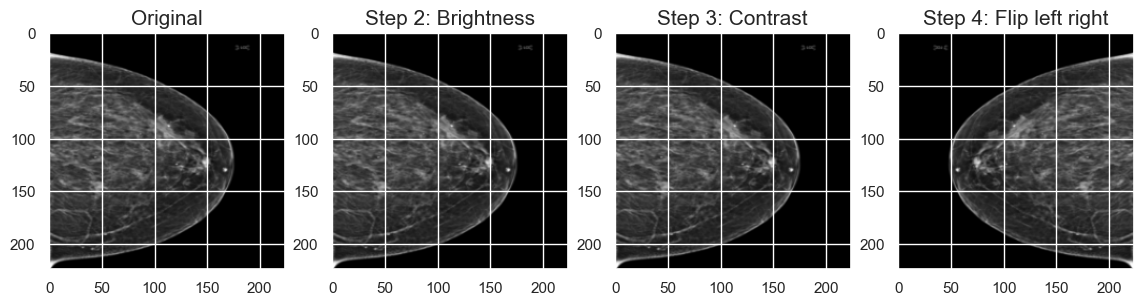

In [8]:
tf.random.set_seed(1234)

fig = plt.figure(figsize=(14, 12))

# pull first image from data
image = images_mini_norm[0]

# plot original
ax = fig.add_subplot(1, 4, 1)
ax.imshow(array_to_img(image))
ax.set_title('Original', size=15);


# adjust brightness
ax = fig.add_subplot(1, 4, 2)
img_bright = tf.image.adjust_brightness(image, -.8)
ax.imshow(array_to_img(img_bright))
ax.set_title('Step 2: Brightness', size=15);


# adjust contrast
ax = fig.add_subplot(1, 4, 3)
img_contrast = tf.image.adjust_contrast(img_bright, contrast_factor=3)
ax.imshow(array_to_img(img_contrast))
ax.set_title('Step 3: Contrast', size=15);


# flip left right
ax = fig.add_subplot(1, 4, 4)
img_flip = tf.image.flip_left_right(img_contrast)
ax.imshow(array_to_img(img_flip))
ax.set_title('Step 4: Flip left right', size=15);


## Split data into train, validate, test

In [11]:
def preprocess_data_part2(images, y, split=(0.6,0.2,0.2)):
    """ Split data into train, validation and test sets; 
    
    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    y (np.ndarray): Labels of shape (N,)   
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 1)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 1)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 1)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    """
    ### create train/validation/test sets ###
    #########################################
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
    tf.random.set_seed(1234)
    np.random.seed(1234)
    shuffle = np.random.permutation(np.arange(images.shape[0]))
    images = images[shuffle]
    y = y[shuffle]
    
    splits = np.multiply(len(images), split).astype(int)
    X_train, X_val, X_test = np.split(images, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y, [splits[0], splits[0]+splits[1]])
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [12]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini_norm,
    y_mini,
    split=(0.6,0.2,0.2)
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"y_train positive cases {sum(y_train)}\n")

print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"y_val positive cases {sum(y_val)}\n")

print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")
print(f"y_test positive cases {sum(y_test)}\n")

X_train shape (3360, 224, 224, 3)
y_train shape (3360,)
y_train positive cases 371

X_val shape (1120, 224, 224, 3)
y_val shape (1120,)
y_val positive cases 114

X_test shape (1120, 224, 224, 3)
y_test shape (1120,)
y_test positive cases 115



## Augmentation

In [13]:
def preprocess_data_part3(X_train, y_train):
    
    # Augment only cancer=1 data
    X_train_w_cancer = X_train[y_train == 1, :, :, :]

    y_train_w_cancer = y_train[y_train == 1]
    
    ### image augmentation on training data ###
    ###########################################
    # adjust brightness
    X_train_augm1 = tf.image.adjust_brightness(X_train_w_cancer, delta=.1)
    X_train_augm2 = tf.image.adjust_brightness(X_train_w_cancer, delta=.2)
    
    # adjust contrast
    X_train_augm5 = tf.image.adjust_contrast(X_train_w_cancer, contrast_factor=1)
    X_train_augm6 = tf.image.adjust_contrast(X_train_w_cancer, contrast_factor=2)

    # random flip
    X_train_augm8 = tf.image.random_flip_left_right(X_train_w_cancer)
    
    # concatenate original X_train and augmented X_train data
    X_train_augm = tf.concat([X_train_augm1, X_train_augm2, X_train_augm5,
                        X_train_augm6, X_train_augm8],axis=0)
    X_train = tf.concat([X_train, X_train_augm],axis=0)
    
    # concatenate y_train (note the label is preserved)
    y_train_augm = tf.convert_to_tensor(np.ones(len(X_train_augm)))
    y_train = tf.concat([y_train, y_train_augm],axis=0)
    
    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array
    
    return X_train, y_train

In [14]:
X_train, y_train = preprocess_data_part3(
    X_train, y_train)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"y_train positive cases {sum(y_train)}\n")

print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"y_val positive cases {sum(y_val)}\n")

print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")
print(f"y_test positive cases {sum(y_test)}\n")

X_train shape (5215, 224, 224, 3)
y_train shape (5215,)
y_train positive cases 2226.0

X_val shape (1120, 224, 224, 3)
y_val shape (1120,)
y_val positive cases 114

X_test shape (1120, 224, 224, 3)
y_test shape (1120,)
y_test positive cases 115



## Calculate class weights

In [15]:
total = len(y_train)
pos = sum(y_train)
neg = total - pos
print('pos:', pos)
print('neg:', neg)
print('total', total)

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

pos: 2226.0
neg: 2989.0
total 5215
Weight for class 0: 0.87
Weight for class 1: 1.17


## Set Batch Size

In [16]:
BATCH_SIZE = 32

## Build vgg16 model

In [18]:
IMG_SIZE = 224
IMG_SHAPE = ( IMG_SIZE, IMG_SIZE, 3)
VGG16_MODEL=tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
VGG16_MODEL.trainable=False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
flatten_layer = tf.keras.layers.Flatten()
extra_dense_layer = tf.keras.layers.Dense(units=1024, activation='relu')
dropout_layer = tf.keras.layers.Dropout(rate=0.5)
prediction_layer = tf.keras.layers.Dense(units=1,activation='sigmoid')


model = tf.keras.Sequential([
  VGG16_MODEL,
  global_average_layer,
  flatten_layer,
  extra_dense_layer,
  dropout_layer,
  prediction_layer
])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                        

In [20]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['AUC','accuracy', recall_m, precision_m, f1_m])

In [28]:
history = model.fit(X_train, y_train,
                    epochs=50, 
                    validation_data=(X_val, y_val),
                    class_weight=class_weights,
                    batch_size = BATCH_SIZE
)

Epoch 1/50
163/163 [==============================] - 283s 2s/step - loss: 0.5915 - auc: 0.7472 - accuracy: 0.6759 - recall_m: 0.6624 - precision_m: 0.6246 - f1_m: 0.6189 - val_loss: 0.5563 - val_auc: 0.6237 - val_accuracy: 0.7143 - val_recall_m: 0.2718 - val_precision_m: 0.1301 - val_f1_m: 0.1700
Epoch 2/50
163/163 [==============================] - 297s 2s/step - loss: 0.5312 - auc: 0.8025 - accuracy: 0.7198 - recall_m: 0.7063 - precision_m: 0.6744 - f1_m: 0.6689 - val_loss: 0.4707 - val_auc: 0.6293 - val_accuracy: 0.8098 - val_recall_m: 0.2399 - val_precision_m: 0.1892 - val_f1_m: 0.2030
Epoch 3/50
163/163 [==============================] - 295s 2s/step - loss: 0.5071 - auc: 0.8244 - accuracy: 0.7417 - recall_m: 0.7364 - precision_m: 0.7040 - f1_m: 0.6990 - val_loss: 0.4746 - val_auc: 0.6239 - val_accuracy: 0.7821 - val_recall_m: 0.2201 - val_precision_m: 0.1757 - val_f1_m: 0.1739
Epoch 4/50
163/163 [==============================] - 297s 2s/step - loss: 0.4607 - auc: 0.8590 - accur

163/163 [==============================] - 293s 2s/step - loss: 0.1015 - auc: 0.9938 - accuracy: 0.9634 - recall_m: 0.9635 - precision_m: 0.9515 - f1_m: 0.9553 - val_loss: 0.6211 - val_auc: 0.5981 - val_accuracy: 0.8527 - val_recall_m: 0.0843 - val_precision_m: 0.1027 - val_f1_m: 0.0820
Epoch 29/50
163/163 [==============================] - 303s 2s/step - loss: 0.1038 - auc: 0.9936 - accuracy: 0.9582 - recall_m: 0.9555 - precision_m: 0.9473 - f1_m: 0.9487 - val_loss: 0.6385 - val_auc: 0.5966 - val_accuracy: 0.8571 - val_recall_m: 0.0690 - val_precision_m: 0.0995 - val_f1_m: 0.0714
Epoch 30/50
163/163 [==============================] - 293s 2s/step - loss: 0.0861 - auc: 0.9960 - accuracy: 0.9664 - recall_m: 0.9660 - precision_m: 0.9562 - f1_m: 0.9593 - val_loss: 0.6983 - val_auc: 0.6131 - val_accuracy: 0.8509 - val_recall_m: 0.1298 - val_precision_m: 0.1429 - val_f1_m: 0.1198
Epoch 31/50
163/163 [==============================] - 294s 2s/step - loss: 0.0852 - auc: 0.9955 - accuracy: 0.9

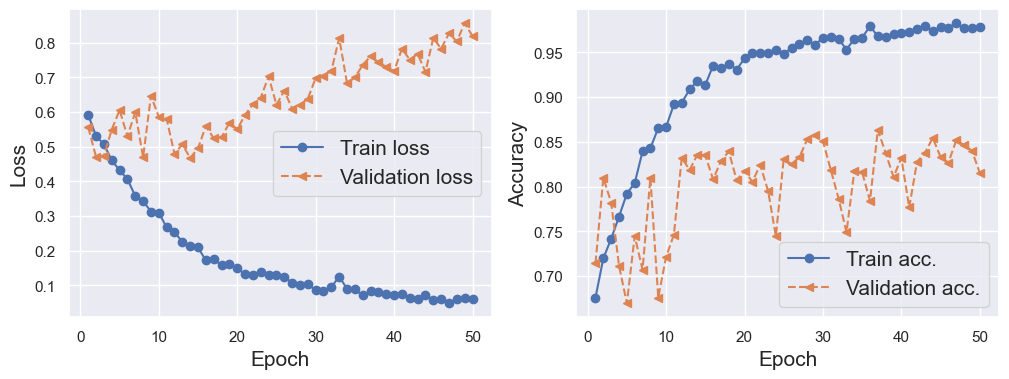

In [29]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

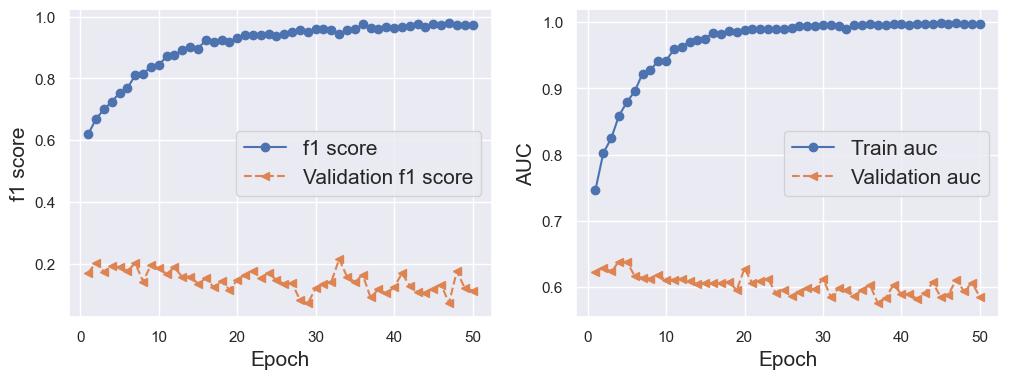

In [35]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['f1_m'], '-o', label='f1 score')
ax.plot(x_arr, hist['val_f1_m'], '--<', label='Validation f1 score')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('f1 score', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['auc'], '-o', label='Train auc')
ax.plot(x_arr, hist['val_auc'], '--<', label='Validation auc')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('AUC', size=15)
plt.show()

In [36]:
y_pred_val = model.predict(X_val)
print(max(y_pred_val))
print(min(y_pred_val))

35/35 [==============================] - 43s 1s/step
[0.99999636]
[5.2362135e-28]


(array([833.,  61.,  40.,  27.,  32.,  26.,  14.,  23.,  18.,  46.]),
 array([5.23621352e-28, 9.99996364e-02, 1.99999273e-01, 2.99998909e-01,
        3.99998546e-01, 4.99998182e-01, 5.99997818e-01, 6.99997425e-01,
        7.99997091e-01, 8.99996758e-01, 9.99996364e-01]),
 <BarContainer object of 10 artists>)

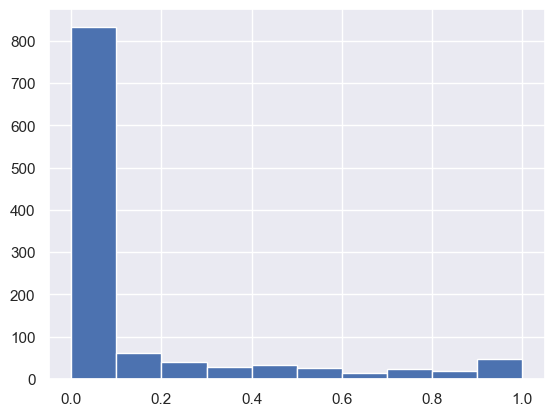

In [37]:
plt.hist(y_pred_val)

(array([1006.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         114.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

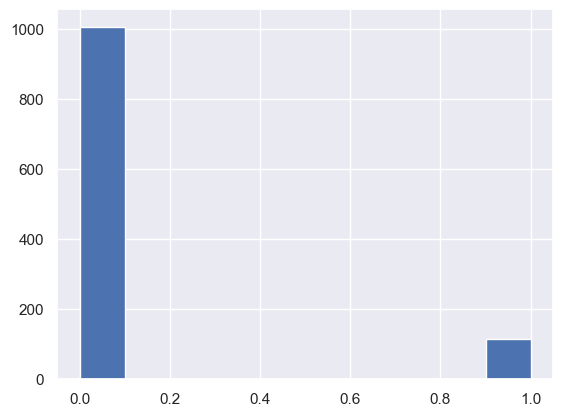

In [38]:
plt.hist(y_val)

(array([993.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 127.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

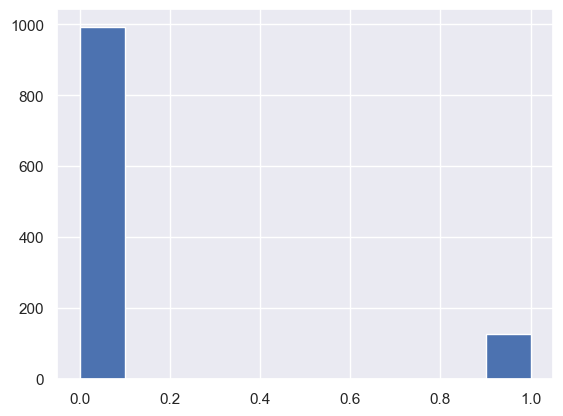

In [40]:
y_pred_val_binary = (y_pred_val >= 0.5).astype(int)
plt.hist(y_pred_val_binary)

In [41]:
tf.math.confusion_matrix(y_val, y_pred_val_binary)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[896, 110],
       [ 97,  17]])>

In [ ]:
# make a confusion matrix at some point....

# Grid Search for hyperparameter tuning

### List of hyperparameters:
#### [augm] Number of augmented images used
#### [augm] Brightness delta
#### [augm] Contrast delta
#### [batch size] batch size
#### [weights] Use of class weights
#### [layers] kernel size
#### [layers] pooling strides
#### [layers] pooling size
#### [layers] pooling max vs average
#### [layers] conv2d strides
#### [activation] sigmoid vs from logits
#### [dropout] rate
#### [lr] learning rate